In [1]:
%%time
%cd /gpfs/data/johnsonslab/nlp-genomics/english_corpora
import pandas as pd
# pd.set_option('display.max_colwidth', None)
import gzip
import re
import tarfile
import os
import youtokentome as yttm
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from collections import defaultdict
import operator
import ftplib
from scipy.optimize import curve_fit
from functools import partial
#import pyperclip
import itertools
#import sentencepiece as spm
%matplotlib inline
from tqdm import tqdm
model_path = "brown_81k.model"
bpe = yttm.BPE(model=model_path)




/gpfs/data/johnsonslab/nlp-genomics/english_corpora
CPU times: user 1.17 s, sys: 424 ms, total: 1.6 s
Wall time: 7.25 s


In [48]:
print(bpe.vocab_size())

81920


### Counting token frequencies

In [2]:
%%time
import operator
freqs = {}
threshold = 0
total_len = 0
total_count = 0
with(open('brown_nowhitelines.txt', 'r')) as f:
    for line in f:
        tokens= bpe.encode(line.strip(), output_type =yttm.OutputType.SUBWORD )
#         tokens = tokenize(line.strip(), length_threshold=threshold)
        total_len +=len(tokens)
        total_count +=1
        for token in tokens:
            if token not in freqs.keys():
                freqs[token] = 1
            else:
                freqs[token]+=1
sorted_freqs = sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)
print(len(sorted_freqs))
print("Average tokenization length: ", total_len/total_count)



67451
Average tokenization length:  74.76363129270673
CPU times: user 2.6 s, sys: 0 ns, total: 2.6 s
Wall time: 2.61 s


4
[[0.         1.        ]
 [0.30103    1.        ]
 [0.47712125 1.        ]
 ...
 [4.82897552 1.        ]
 [4.82898195 1.        ]
 [4.82898839 1.        ]] [[4.79548376]
 [4.55507025]
 [4.43828913]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


Text(0, 0.5, 'Log10 Frequency')

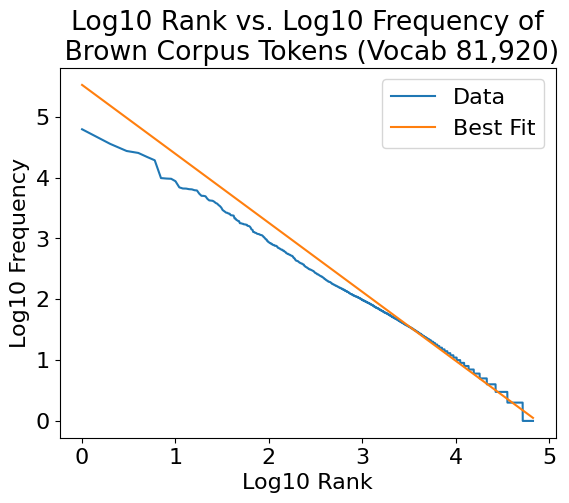

In [5]:
sorted_freq_values = []
sorted_freq_lengths = []
freq_threshold=0
print(len(sorted_freqs[0][0]))
for freq in sorted_freqs:
    sorted_freq_values.append(freq[1])
    if(freq[1]>freq_threshold):
#         if(freq[0][0]=="_"):
#             sorted_freq_lengths.append(len(freq[0][1:]))
#         else:
        sorted_freq_lengths.append(len(freq[0]))

ranks = np.arange(1, len(sorted_freqs) + 1)
x = np.log10(ranks).reshape(len(ranks), 1)
X = np.append(x, np.ones((len(ranks), 1)), axis=1)
y = np.array(np.log10(sorted_freq_values)).reshape(len(sorted_freq_values), 1)
print(X, y)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
plt.plot(np.log10(ranks), np.log10(sorted_freq_values))
plt.plot(x, y_line)
plt.rcParams.update({'font.size': 16})
plt.title('Log10 Rank vs. Log10 Frequency of\n Brown Corpus Tokens (Vocab 81,920)')
plt.legend(['Data', 'Best Fit'])
plt.xlabel('Log10 Rank')
plt.ylabel('Log10 Frequency')

In [51]:
total = 0 
for i in range(1, len(sorted_freq_values)):
    total+= sorted_freq_values[i-1]
    if total>=sum(sorted_freq_values)/2:
        break
print("number of types to reach 50%: ", i)
print(i/len(sorted_freq_values) * 100, "% of types make up half of all tokens")

number of types to reach 50%:  292
0.43290685089917125 % of types make up half of all tokens


In [52]:
sfv_array = np.array(sorted_freq_values)
singles = sfv_array[sfv_array<=1]
print(len(singles), "types only appear once in all tokenizations")
print(len(singles)/len(sorted_freq_values) * 100, "% of all types only appear once")
print("Half of all types appear", sorted_freq_values[int(len(sorted_freq_values)/2)], "times or fewer")


15184 types only appear once in all tokenizations
22.511156246756904 % of all types only appear once
Half of all types appear 3 times or fewer


Text(0, 0.5, 'Frequency')

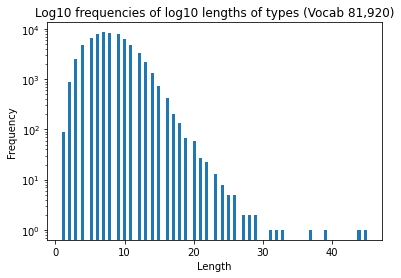

In [53]:
# print(sorted_freq_lengths.index(0))
plt.hist((sorted_freq_lengths), bins=100, log=True)
plt.title("Log10 frequencies of log10 lengths of types (Vocab 81,920)")
plt.xlabel("Length")
plt.ylabel("Frequency")

In [54]:
print(bpe.decode([3082]))

['ox']


In [55]:
print(sorted_freqs[3082])

('_', 36)


In [2]:
import pickle
class BPE():
    def __init__(self, vocab_size, corpus, unk="<UNK>"):
        self.vocab_size = vocab_size
        self.corpus = [[c for c in line[: len(line) if line.find("\n") == -1 else -1] ] for line in corpus]
        self.vocab = set()
        self.merge = {}
        self.unk = unk
        for line in self.corpus:
            self.vocab = self.vocab.union(set(line))
        self.init_vocab_size = len(self.vocab)
        self.vocab = list(self.vocab)
        self.vocab = [self.unk] + self.vocab
        self.vocab = dict(zip(self.vocab, list(range(len(self.vocab)))))
        
        
    def train(self):
        corpus = self.corpus
        pair_freqs = {}
        new_corpus = []
        ##get most frequent tokens
        for i in range(self.init_vocab_size, self.vocab_size):
            for line in corpus:
                for i in range(len(line)-1):
                    if (line[i], line[i+1]) in pair_freqs.keys():
                        pair_freqs[(line[i], line[i+1])] += 1
                    else:
                        pair_freqs[(line[i], line[i+1])] = 1
            max_pair = max(pair_freqs, key=pair_freqs.get)
            new_token = "".join(max_pair)
            # print(new_token)
            self.merge[max_pair] = new_token
            self.vocab[new_token] = max(self.vocab.values()) + 1
            for line in corpus:
                    # print("pristine line:", line)
                for i in range(len(line)-1):
                    # print("i:", i)
                    # print(i)
                    if i < len(line)-1:
                        if line[i] == max_pair[0] and line[i + 1] == max_pair[1]:
                            line[i] = new_token
                            line.pop(i+1)
                                # print(len(line))
         
                            # print(line)
            # corpus = new_corpus
        # print(corpus)

    def tokenize(self, strings, ids=True):
        if type(strings)!= list:
            assert type(strings) == str, "input must be string or list of strings"
            strings = [strings]
        tokenized_strings = []
        for string in strings:
            string = list(string)
            while True:
                cur_len = len(string)
                for i in range(len(string)-1):
                    if i < len(string)-1:
                        if (string[i], string[i+1]) in self.merge.keys():
                            string[i] = self.merge[(string[i], string[i+1])]
                            string.pop(i+1)
                if len(string)== cur_len:
                    if ids:
                        tokenized_strings.append([self.vocab[s] if s in self.vocab.keys() else self.vocab[self.unk] for s in string])
                    else:
                        all_in_vocab = True
                        for i in range(len(string)):
                            all_in_vocab = string[i] in self.vocab.keys()
                            if not all_in_vocab:
                                string[i] = self.unk
                            
                        tokenized_strings.append(string)
                    break
                else:
                    cur_len = len(string)
        return tokenized_strings
    def save(self, path):
        with open(path, 'wb') as out:
            pickle.dump(self, out, pickle.HIGHEST_PROTOCOL)

# bpe = BPE(10, ["testing, testinggg", "testing"])
# bpe.save('/gpfs/data/johnsonslab/nlp-genomics/english_corpora/test_custom.pkl')         
# with open('/gpfs/data/johnsonslab/nlp-genomics/english_corpora/test_custom.pkl', 'rb') as inp:
#     bpe = pickle.load(inp)
# bpe.train()
# bpe.tokenize(["testingz"], ids=True)

  

In [5]:
import pickle
with open("/gpfs/data/johnsonslab/nlp-genomics/english_corpora/brown_custom_81920.pkl", "rb") as inp:
    bpe = pickle.load(inp)


In [6]:
from tqdm import tqdm
freqs = {}
with open('/gpfs/data/johnsonslab/nlp-genomics/english_corpora/brown_nowhitelines.txt', 'r') as f:
    for line in tqdm(f.readlines()):
        tokens = bpe.tokenize(line[:-1], ids=False)
        
        for token in tokens[0]:
            if token not in freqs.keys():
                freqs[token] = 1
            else:
                freqs[token] +=1


100%|██████████| 14342/14342 [00:06<00:00, 2165.19it/s]


2
[[0.         1.        ]
 [0.30103    1.        ]
 [0.47712125 1.        ]
 ...
 [3.56913973 1.        ]
 [3.56925683 1.        ]
 [3.56937391 1.        ]] [[4.79309859]
 [4.79150819]
 [4.74731857]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


Text(0, 0.5, 'Log10 Frequency')

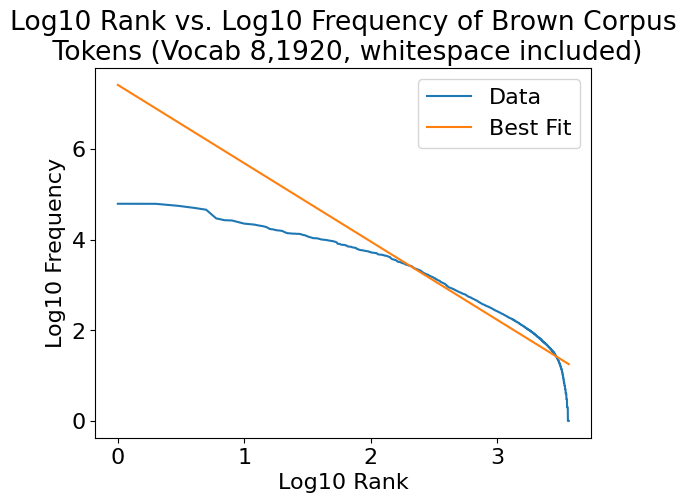

In [8]:
sorted_freqs = sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)
sorted_freq_values = []
sorted_freq_lengths = []
freq_threshold=0
print(len(sorted_freqs[0][0]))
for freq in sorted_freqs:
    sorted_freq_values.append(freq[1])
    if(freq[1]>freq_threshold):
        if(freq[0][0]=="_"):
            sorted_freq_lengths.append(len(freq[0][1:]))
        else:
            sorted_freq_lengths.append(len(freq[0]))

ranks = np.arange(1, len(sorted_freqs) + 1)
x = np.log10(ranks).reshape(len(ranks), 1)
X = np.append(x, np.ones((len(ranks), 1)), axis=1)
y = np.array(np.log10(sorted_freq_values)).reshape(len(sorted_freq_values), 1)
print(X, y)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
plt.plot(np.log10(ranks), np.log10(sorted_freq_values))
plt.plot(x, y_line)
plt.rcParams.update({'font.size': 16})
plt.title('Log10 Rank vs. Log10 Frequency of Brown Corpus\n Tokens (Vocab 8,1920, whitespace included)')
plt.legend(['Data', 'Best Fit'])
plt.xlabel('Log10 Rank')
plt.ylabel('Log10 Frequency')